In [5]:
# base model RoBERT : bidirectional - attension이 양방향

# dataset load

In [1]:
! git clone https://github.com/declare-lab/MELD/
! DIR

fatal: destination path 'MELD' already exists and is not an empty directory.


 D ����̺��� ����: �� ����
 ���� �Ϸ� ��ȣ: 24A6-FBE8

 d:\ideaproject\nlp ���͸�

2022-10-24  ���� 05:48    <DIR>          .
2022-10-24  ���� 05:48    <DIR>          ..
2022-10-24  ���� 05:48    <DIR>          .ipynb_checkpoints
2022-10-24  ���� 05:48    <DIR>          MELD
2022-10-24  ���� 05:18                72 Untitled.ipynb
2022-10-24  ���� 05:43             6,846 Untitled1.ipynb
               2�� ����               6,918 ����Ʈ
               4�� ���͸�  499,971,239,936 ����Ʈ ����


In [2]:
import glob
data_path = "./MELD/data/MELD/*.csv"
data_path_list = glob.glob(data_path)
print(data_path_list)

['./MELD/data/MELD\\dev_sent_emo.csv', './MELD/data/MELD\\test_sent_emo.csv', './MELD/data/MELD\\train_sent_emo.csv']


In [3]:
#!head -5 './MELD/data/MELD\\dev_sent_emo.csv'

In [4]:
import csv
for data_path in data_path_list:
    f = open(data_path, 'r',encoding='utf-8')
    rdr = csv.reader(f)
    
    for line in rdr:
        print(line)
        break
    
    f.close()
    break

['Sr No.', 'Utterance', 'Speaker', 'Emotion', 'Sentiment', 'Dialogue_ID', 'Utterance_ID', 'Season', 'Episode', 'StartTime', 'EndTime']


# preprocessing exam

In [7]:
# session이 왔을 때 각 데이터 예측을 위해 데이터 분할
# [문장1, 문장2, 문장3] -> 문장3 감정 예측
# [문장1], [문장1, 문장2]
def split(session):
    final_data = []
    split_session = []
    for line in session:
        split_session.append(line)
        final_data.append(split_session[:])    
    return final_data
    
for data_path in data_path_list:
    f = open(data_path, 'r', encoding='utf-8')
    rdr = csv.reader(f)
    
    '''Dialogue_ID당 데이터 묶기'''
    session_dataset = []
    session = []
    speaker_set = []
    
    
    pre_sess = 'start'
    for i, line in enumerate(rdr):
        if i == 0:
            header  = line
            utt_idx = header.index('Utterance')
            speaker_idx = header.index('Speaker')
            emo_idx = header.index('Emotion')
            sess_idx = header.index('Dialogue_ID')
        else:
            utt = line[utt_idx]
            speaker = line[speaker_idx]

            ''' Dialogue_ID 당 speaker 특정할 수 있도록 index 삽입'''
            if speaker in speaker_set:
                uniq_speaker = speaker_set.index(speaker)
            else:
                speaker_set.append(speaker)
                uniq_speaker = speaker_set.index(speaker)
            emotion = line[emo_idx]
            sess = line[sess_idx]
            
            if pre_sess == 'start' or sess == pre_sess:
                session.append([uniq_speaker, utt, emotion])
            else:
                # session_dataset.append(session)
                session_dataset += split(session)
                session = [[uniq_speaker, utt, emotion]]
                speaker_set = []
            pre_sess = sess   
    
    # session_dataset.append(session)
    session_dataset += split(session)
    f.close()
    
    break

In [9]:
session_dataset[0]
session_dataset[5]

[[2,
  'Or! Or, we could go to the bank, close our accounts and cut them off at the source.',
  'neutral'],
 [0, 'You’re a genius!', 'joy'],
 [1, 'Aww, man, now we won’t be bank buddies!', 'sadness'],
 [0, 'Now, there’s two reasons.', 'neutral']]

# data loader

In [2]:
import csv
from torch.utils.data import Dataset
def split(session):
    final_data = []
    split_session = []
    for line in session:
        split_session.append(line)
        final_data.append(split_session[:])    
    return final_data

class data_loader(Dataset):
    def __init__(self, data_path):
        f = open(data_path, 'r', encoding='utf-8')
        rdr = csv.reader(f)
        
        '''감정'''
        emoSet = set()
        '''Dialogue_ID당 데이터 묶기'''
        self.session_dataset = []
        session = []
        speaker_set = []

        pre_sess = 'start'
        for i, line in enumerate(rdr):
            if i == 0:
                header  = line
                utt_idx = header.index('Utterance')
                speaker_idx = header.index('Speaker')
                emo_idx = header.index('Emotion')
                sess_idx = header.index('Dialogue_ID')
            else:
                utt = line[utt_idx]
                speaker = line[speaker_idx]
                ''' Dialogue_ID 당 speaker 특정할 수 있도록 index 삽입'''
                if speaker in speaker_set:
                    uniq_speaker = speaker_set.index(speaker)
                else:
                    speaker_set.append(speaker)
                    uniq_speaker = speaker_set.index(speaker)
                emotion = line[emo_idx]
                sess = line[sess_idx]

                if pre_sess == 'start' or sess == pre_sess:
                    session.append([uniq_speaker, utt, emotion])
                else:
                    self.session_dataset += split(session)
                    session = [[uniq_speaker, utt, emotion]]
                    speaker_set = []
                    emoSet.add(emotion)
                pre_sess = sess   
        """ 마지막 세션 저장 """
        self.session_dataset += split(session)
            
        # self.emoList = sorted(emoSet) # 항상 같은 레이블 순서를 유지하기 위해
        self.emoList = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
        f.close()
        
    def __len__(self): 
        return len(self.session_dataset)
    
    def __getitem__(self, idx): 
        return self.session_dataset[idx]
    
    def collate_fn(self, sessions): # 배치를 위한 구성
        '''
            input:
                data: [(session1), (session2), ... ]
            return:
                batch_input_tokens_pad: (B, L) padded
                batch_labels: (B)
        '''
        batch_input_token = []
        for session in sessions:
            input_token = ""
            for line in session:
                speaker, utt, emotion = line
                input_token += utt
            batch_input_token.append(input_token)
        
        return batch_input_token

In [3]:
dev_dataset = data_loader('./MELD/data/MELD/dev_sent_emo.csv')
dev_dataset[0], dev_dataset[1]

([[0, 'Oh my God, he’s lost it. He’s totally lost it.', 'sadness']],
 [[0, 'Oh my God, he’s lost it. He’s totally lost it.', 'sadness'],
  [1, 'What?', 'surprise']])

In [15]:
""" 배치 결과 확인 """
from torch.utils.data import DataLoader
dev_dataloader = DataLoader(dev_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=dev_dataset.collate_fn)

i = 0
for data in dev_dataloader:
    print(i, data)
    i += 1
    if i > 2:
        break    

### 사전 학습 모델

In [1]:
""" 토크나이저 확인하기 """
# https://github.com/thunlp/PLMpapers
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

In [9]:
print(tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token)
print(tokenizer.cls_token_id, tokenizer.sep_token_id, tokenizer.pad_token_id)

<s> </s> <pad>
0 2 1


In [10]:
# dir(tokenizer)
tokenizer.model_max_length

512

### tokenizer exam

In [11]:
""" 토크나이저 작동 """
res = tokenizer('hello. this is fastcampus')
print(res)
res = tokenizer.encode('hello. this is fastcampus')
print(res)
res = tokenizer(['hello. this is fastcampus', "what are you doing?"])
print(res)
res = tokenizer(['hello. this is fastcampus', "what are you doing?"], add_special_tokens=False)
print(res)

{'input_ids': [0, 42891, 4, 42, 16, 1769, 28135, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
[0, 42891, 4, 42, 16, 1769, 28135, 2]
{'input_ids': [[0, 42891, 4, 42, 16, 1769, 28135, 2], [0, 12196, 32, 47, 608, 116, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]}
{'input_ids': [[42891, 4, 42, 16, 1769, 28135], [12196, 32, 47, 608, 116]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]}


In [9]:
""" 배치 입력 토큰들 처리 """
from torch.utils.data import Dataset
from transformers import RobertaTokenizer
import csv
from torch.utils.data import Dataset
import torch

def split(session):
    final_data = []
    split_session = []
    for line in session:
        split_session.append(line)
        final_data.append(split_session[:])    
    return final_data

class data_loader(Dataset):
    def __init__(self, data_path):
        f = open(data_path, 'r', encoding='utf-8')
        rdr = csv.reader(f)
        
        
        emoSet = set()
        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

        '''Dialogue_ID당 데이터 묶기'''
        self.session_dataset = []
        session = []
        speaker_set = []

        
        pre_sess = 'start'
        for i, line in enumerate(rdr):
            if i == 0:
                """ 저장할 데이터들 index 확인 """
                header  = line
                utt_idx = header.index('Utterance')
                speaker_idx = header.index('Speaker')
                emo_idx = header.index('Emotion')
                sess_idx = header.index('Dialogue_ID')
            else:
                utt = line[utt_idx]
                speaker = line[speaker_idx]
                ''' Dialogue_ID 당 speaker 특정할 수 있도록 index 삽입'''
                if speaker in speaker_set:
                    uniq_speaker = speaker_set.index(speaker)
                else:
                    speaker_set.append(speaker)
                    uniq_speaker = speaker_set.index(speaker)
                emotion = line[emo_idx]
                sess = line[sess_idx]

                if pre_sess == 'start' or sess == pre_sess:
                    session.append([uniq_speaker, utt, emotion])
                else:
                    
                    self.session_dataset += split(session)
                    session = [[uniq_speaker, utt, emotion]]
                    speaker_set = []
                    emoSet.add(emotion)
                pre_sess = sess   
        """ 마지막 세션 저장 """
        self.session_dataset += split(session)
            
        # self.emoList = sorted(emoSet) # 항상 같은 레이블 순서를 유지하기 위해
        self.emoList = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
        f.close()
        
    def __len__(self): 
        return len(self.session_dataset)
    
    def __getitem__(self, idx):
        return self.session_dataset[idx]
    
    def padding(self, batch_input_token):
        
        """ 토큰 길이 넘으면 잘라내기 """
        batch_token_ids, batch_attention_masks = batch_input_token['input_ids'], batch_input_token['attention_mask']
        trunc_batch_token_ids, trunc_batch_attention_masks = [], []
        for batch_token_id, batch_attention_mask in zip(batch_token_ids, batch_attention_masks):
            if len(batch_token_id) > self.tokenizer.model_max_length:
                trunc_batch_token_id = [batch_token_id[0]] + batch_token_id[1:][-self.tokenizer.model_max_length+1:]
                ''' 마지막 발화를 기준으로 뒤에서 부터 자르기 '''
                trunc_batch_attention_mask = [batch_attention_mask[0]] + batch_attention_mask[1:][-self.tokenizer.model_max_length+1:]
                trunc_batch_token_ids.append(trunc_batch_token_id)
                trunc_batch_attention_masks.append(trunc_batch_attention_mask)
            else:
                trunc_batch_token_ids.append(batch_token_id)
                trunc_batch_attention_masks.append(batch_attention_mask)
        
        """ padding token으로 패딩하기 """
        max_length = max([len(x) for x in trunc_batch_token_ids])
        padding_tokens, padding_attention_masks = [], []
        for batch_token_id, batch_attention_mask in zip(trunc_batch_token_ids, trunc_batch_attention_masks):
            padding_tokens.append(batch_token_id + [self.tokenizer.pad_token_id for _ in range(max_length-len(batch_token_id))])
            padding_attention_masks.append(batch_attention_mask + [0 for _ in range(max_length-len(batch_token_id))])
        return torch.tensor(padding_tokens), torch.tensor(padding_attention_masks)
    
    def collate_fn(self, sessions): # 배치를 위한 구성
        '''
            input:
                data: [(session1), (session2), ... ]
            return:
                batch_input_tokens_pad: (B, L) padded
                batch_labels: (B)
        '''
        ## [발화1, 발화2, ..., 발화8]
        # 발화1~발화7 컨텍스트로 사용한다면 입력이 길어진다.
        # 발화1 같은 경우는 발화8에 덜중요할거에요.
        # 적절하게 컨텍스트 길이를 조절해도된다.
        # 3개로 정한다면, [발화5,발화6,발화7,발화8]
        
        batch_input, batch_labels = [], []
        batch_PM_input = []
        for session in sessions:
            input_str = self.tokenizer.cls_token
            
            """ For PM """
            current_speaker, current_utt, current_emotion = session[-1]
            PM_input = []
            for i, line in enumerate(session):
                speaker, utt, emotion = line
                input_str += " " + utt + self.tokenizer.sep_token
                if i < len(session)-1 and current_speaker == speaker:
                    PM_input.append(self.tokenizer.encode(utt, add_special_tokens=True, return_tensors='pt'))
                    # [cls_token, tokens, sep_token]
                    
            """ For CoM """
            batch_input.append(input_str)
            batch_labels.append(self.emoList.index(emotion))
            batch_PM_input.append(PM_input)
        batch_input_token = self.tokenizer(batch_input, add_special_tokens=False)
        batch_padding_token, batch_padding_attention_mask = self.padding(batch_input_token)
        
        return batch_padding_token, batch_padding_attention_mask, batch_PM_input, torch.tensor(batch_labels)

In [4]:
""" 배치 결과 확인 """
from torch.utils.data import DataLoader
dev_dataset = data_loader('./MELD/data/MELD/dev_sent_emo.csv')
dev_dataloader = DataLoader(dev_dataset, batch_size=3, shuffle=False, num_workers=4, collate_fn=dev_dataset.collate_fn)

for i, data in enumerate(dev_dataloader):
    if i == 1:
        print(data[0].shape)
        batch_padding_token, batch_padding_attention_mask, batch_PM_input, batch_label = data
        print("batch_padding_token", batch_padding_token)
        print("batch_padding_attention_mask", batch_padding_attention_mask)
        print("batch_PM_input", batch_PM_input)
        print("batch_label", batch_label)
        break

# 파일 만들기

In [2]:
!touch dataset.py
# 빈 파이썬파일 생성

In [ ]:
from dataset import data_loader
from torch.utils.data import DataLoader
dev_dataset = data_loader('./MELD/data/MELD/dev_sent_emo.csv')
dev_dataloader = DataLoader(dev_dataset, batch_size=3, shuffle=False, num_workers=4, collate_fn=dev_dataset.collate_fn)

for i, data in enumerate(dev_dataloader):
    if i == 1:
        print(data[0].shape)
        batch_padding_token, batch_padding_attention_mask, batch_PM_input, batch_label = data
        print("batch_padding_token", batch_padding_token)
        print("batch_padding_attention_mask", batch_padding_attention_mask)
        print("batch_PM_input", batch_PM_input)
        print("batch_label", batch_label)
        break

In [2]:
from transformers import RobertaModel
model = RobertaModel.from_pretrained('roberta-base')
print('')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
model
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_auto_class',
 '_backward_compatibility_gradient_checkpointing',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_can_retrieve_inputs_from_name',
 '_convert_head_mask_to_5d',
 '_create_or_get_repo',
 '_expand_inputs_for_generation',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_from_config',
 '_get_backward_hooks',
 '_get_decoder_start_token_id',
 '_get_logits_processor',
 '_get_logits_warper',
 '_get_name',
 '_get_repo_url_from_name',
 '_get_resized_embeddings',
 '_get_resized_lm_head',
 '_get_stopping_criteria',
 '_hook_rss_

In [10]:
batch_padding_token.shape, batch_padding_attention_mask.shape

NameError: name 'batch_padding_token' is not defined

In [ ]:
batch_padding_token, batch_padding_attention_mask

In [ ]:
""" for CoM """
batch_com_out = model(input_ids=batch_padding_token, attention_mask=batch_padding_attention_mask)['last_hidden_state']
print(batch_com_out.shape)
batch_com_final = batch_com_out[:,0,:] # CLS 토큰의 output 가져오기 위해
print(batch_com_final.shape)

In [ ]:
# result = model(input_ids=batch_padding_token, attention_mask=batch_padding_attention_mask)
# result.keys()

In [ ]:
import torch

model2 = RobertaModel.from_pretrained('roberta-base')
# 발화1: feature1 [1, 768]
# 발화3: feature3 [1, 768]
# 발화6에 해당하는 감정을 예측할 때 발화1, 발화3의 정보를 사용할 것
# feature1 + feature3
# (feature1, feature6) 어텐션 weights w1
# (feature3, feature6) 어텐션 weights w3
# w1*feature1 + w3*feature6
# GRU(feature1, feature3)

""" GRU 세팅 """
import torch.nn as nn 
hiddenDim = model2.config.hidden_size
zero = torch.empty(2, 1, hiddenDim)
h0 = torch.zeros_like(zero) # (num_layers * num_directions, batch, hidden_size)
speakerGRU = nn.GRU(hiddenDim, hiddenDim, 2, dropout=0.3) # (input, hidden, num_layer) (BERT_emb, BERT_emb, num_layer)

""" GRU 통과 --> PM 결과 """
batch_pm_gru_final = []
for PM_inputs in batch_PM_input:
    if PM_inputs:
        pm_outs = []
        for PM_input in PM_inputs:
            pm_out = model2(PM_input)['last_hidden_state'][:,0,:] # CLS의 출력
            pm_outs.append(pm_out)
        pm_outs = torch.cat(pm_outs, 0).unsqueeze(1) # (speaker_num, batch=1, hidden_dim)
        pm_gru_outs, _ = speakerGRU(pm_outs, h0) # (speaker_num, batch=1, hidden_dim)
        pm_gru_final = pm_gru_outs[-1,:,:] # (1, hidden_dim)
        batch_pm_gru_final.append(pm_gru_final)
    else:
        batch_pm_gru_final.append(torch.zeros(1, hiddenDim))
batch_pm_gru_final = torch.cat(batch_pm_gru_final, 0)

### 추가 layer

In [ ]:
""" score matrix """
clsNum = len(dev_dataset.emoList)
W = nn.Linear(hiddenDim, clsNum)
final_output = W(batch_com_final + batch_pm_gru_final)
print(final_output.shape) # (B, C)

In [1]:
from transformers import RobertaModel
import torch
import torch.nn as nn

class ERC_model(nn.Module):
    def __init__(self, clsNum):
        super(ERC_model, self).__init__()
        self.com_model = RobertaModel.from_pretrained('roberta-base')
        self.pm_model = RobertaModel.from_pretrained('roberta-base')
        
        """ GRU 세팅 """
        self.hiddenDim = self.com_model.config.hidden_size
        zero = torch.empty(2, 1, self.hiddenDim)
        self.h0 = torch.zeros_like(zero) # (num_layers * num_directions, batch, hidden_size)
        self.speakerGRU = nn.GRU(self.hiddenDim, self.hiddenDim, 2, dropout=0.3) # (input, hidden, num_layer) (BERT_emb, BERT_emb, num_layer)
        
        """ score matrix """
        self.W = nn.Linear(self.hiddenDim, clsNum)
    def forward(self, batch_padding_token, batch_padding_attention_mask, batch_PM_input):
        """ for CoM """
        batch_com_out = self.com_model(input_ids=batch_padding_token, attention_mask=batch_padding_attention_mask)['last_hidden_state']
        batch_com_final = batch_com_out[:,0,:]
        
        """ GRU 통과 --> PM 결과 """
        batch_pm_gru_final = []
        for PM_inputs in batch_PM_input:
            if PM_inputs:
                pm_outs = []
                for PM_input in PM_inputs:
                    pm_out = self.pm_model(PM_input)['last_hidden_state'][:,0,:]
                    pm_outs.append(pm_out)
                pm_outs = torch.cat(pm_outs, 0).unsqueeze(1) # (speaker_num, batch=1, hidden_dim)
                pm_gru_outs, _ = self.speakerGRU(pm_outs, self.h0) # (speaker_num, batch=1, hidden_dim)
                pm_gru_final = pm_gru_outs[-1,:,:] # (1, hidden_dim)
                batch_pm_gru_final.append(pm_gru_final)
            else:
                batch_pm_gru_final.append(torch.zeros(1, self.hiddenDim))
        batch_pm_gru_final = torch.cat(batch_pm_gru_final, 0)        
        
        """ score matrix """
        final_output = self.W(batch_com_final + batch_pm_gru_final) # (B, C)
        
        return final_output

In [ ]:
clsNum = len(dev_dataset.emoList)
model = ERC_model(clsNum)
result = model(batch_padding_token, batch_padding_attention_mask, batch_PM_input)
print(result.shape)

### 파일로 저장

In [ ]:
!touch model.py

### 평가

In [ ]:
## GPU 작동 모델 수정 GPU
from transformers import RobertaModel
import torch
import torch.nn as nn

class ERC_model(nn.Module):
    def __init__(self, clsNum):
        super(ERC_model, self).__init__()
        self.com_model = RobertaModel.from_pretrained('roberta-base')
        self.pm_model = RobertaModel.from_pretrained('roberta-base')
        
        """ GRU 세팅 """
        self.hiddenDim = self.com_model.config.hidden_size
        zero = torch.empty(2, 1, self.hiddenDim)
        self.h0 = torch.zeros_like(zero).cuda() # (num_layers * num_directions, batch, hidden_size)
        self.speakerGRU = nn.GRU(self.hiddenDim, self.hiddenDim, 2, dropout=0.3) # (input, hidden, num_layer) (BERT_emb, BERT_emb, num_layer)
        
        """ score matrix """
        self.W = nn.Linear(self.hiddenDim, clsNum)
    def forward(self, batch_padding_token, batch_padding_attention_mask, batch_PM_input):
        """ for CoM """
        batch_com_out = self.com_model(input_ids=batch_padding_token, attention_mask=batch_padding_attention_mask)['last_hidden_state']
        batch_com_final = batch_com_out[:,0,:]
        
        """ GRU 통과 --> PM 결과 """
        batch_pm_gru_final = []
        for PM_inputs in batch_PM_input:
            if PM_inputs:
                pm_outs = []
                for PM_input in PM_inputs:
                    pm_out = self.pm_model(PM_input)['last_hidden_state'][:,0,:]
                    pm_outs.append(pm_out)
                pm_outs = torch.cat(pm_outs, 0).unsqueeze(1) # (speaker_num, batch=1, hidden_dim)
                pm_gru_outs, _ = self.speakerGRU(pm_outs, self.h0) # (speaker_num, batch=1, hidden_dim)
                pm_gru_final = pm_gru_outs[-1,:,:] # (1, hidden_dim)
                batch_pm_gru_final.append(pm_gru_final)
            else:
                batch_pm_gru_final.append(torch.zeros(1, self.hiddenDim).cuda())
        batch_pm_gru_final = torch.cat(batch_pm_gru_final, 0)        
        
        """ score matrix """
        final_output = self.W(batch_com_final + batch_pm_gru_final) # (B, C)
        
        return final_output

In [2]:
import torch
from tqdm import tqdm
def CalACC(model, dataloader):
    model.eval()
    correct = 0
    label_list = []
    pred_list = []
    
    # label arragne
    with torch.no_grad():
        for i_batch, data in enumerate(tqdm(dataloader)):
            """Prediction"""
            batch_padding_token, batch_padding_attention_mask, batch_PM_input, batch_label = data
            batch_padding_token = batch_padding_token.cuda()
            batch_padding_attention_mask = batch_padding_attention_mask.cuda()
            batch_PM_input = [[x2.cuda() for x2 in x1] for x1 in batch_PM_input]
            batch_label = batch_label.cuda()        

            """Prediction"""
            pred_logits = erc_model(batch_padding_token, batch_padding_attention_mask, batch_PM_input)
            
            """Calculation"""    
            pred_label = pred_logits.argmax(1).item()
            true_label = batch_label.item()
            
            pred_list.append(pred_label)
            label_list.append(true_label)
            if pred_label == true_label:
                correct += 1
        acc = correct/len(dataloader)
    return acc, pred_list, label_list

In [3]:
from dataset import data_loader
from torch.utils.data import DataLoader

train_dataset = data_loader('./MELD/data/MELD/train_sent_emo.csv')
dev_dataset = data_loader('./MELD/data/MELD/dev_sent_emo.csv')
test_dataset = data_loader('./MELD/data/MELD/test_sent_emo.csv')

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4, collate_fn=train_dataset.collate_fn)
dev_dataloader = DataLoader(dev_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=dev_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=test_dataset.collate_fn)

In [4]:
len(train_dataloader), len(dev_dataloader), len(test_dataloader)

(9989, 1109, 2610)

In [5]:
from model import ERC_model
clsNum = len(train_dataset.emoList)
erc_model = ERC_model(clsNum).cuda()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaMod

In [6]:
from sklearn.metrics import precision_recall_fscore_support
dev_acc, dev_pred_list, dev_label_list = CalACC(erc_model, dev_dataloader)
dev_pre, dev_rec, dev_fbeta, _ = precision_recall_fscore_support(dev_label_list, dev_pred_list, average='weighted')

100%|██████████| 1109/1109 [00:22<00:00, 50.35it/s]
c:\Users\answl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import torch.nn as nn
def CELoss(pred_outs, labels):
    """
        pred_outs: [batch, clsNum]
        labels: [batch]
    """
    loss = nn.CrossEntropyLoss()
    loss_val = loss(pred_outs, labels)
    return loss_val

In [ ]:
import torch
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
import pdb

training_epochs = 5
max_grad_norm = 10
lr = 1e-6
num_training_steps = len(train_dataset)*training_epochs
num_warmup_steps = len(train_dataset)
optimizer = torch.optim.AdamW(erc_model.parameters(), lr=lr) # , eps=1e-06, weight_decay=0.01
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

for epoch in tqdm(range(training_epochs)):
    erc_model.train() 
    for i_batch, data in enumerate(train_dataloader):
        batch_padding_token, batch_padding_attention_mask, batch_PM_input, batch_label = data
        batch_padding_token = batch_padding_token.cuda()
        batch_padding_attention_mask = batch_padding_attention_mask.cuda()
        batch_PM_input = [[x2.cuda() for x2 in x1] for x1 in batch_PM_input]
        batch_label = batch_label.cuda()        
        
        """Prediction"""
        pred_logits = erc_model(batch_padding_token, batch_padding_attention_mask, batch_PM_input)
        
        """Loss calculation & training"""
        loss_val = CELoss(pred_logits, batch_label)
        
        loss_val.backward()
        torch.nn.utils.clip_grad_norm_(erc_model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()        
        break
    break

### 모델 저장

import os
def SaveModel(model, path):
    if not os.path.exists(path):
        os.makedirs(path)
    torch.save(model.state_dict(), os.path.join(path, 'model.bin'))

# 최종 코드

In [ ]:
import torch
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

training_epochs = 5
max_grad_norm = 10
lr = 1e-6
num_training_steps = len(train_dataset)*training_epochs
num_warmup_steps = len(train_dataset)
optimizer = torch.optim.AdamW(erc_model.parameters(), lr=lr) # , eps=1e-06, weight_decay=0.01
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

best_dev_fscore = 0
save_path = '.'
for epoch in tqdm(range(training_epochs)):
    erc_model.train() 
    for i_batch, data in enumerate(tqdm(train_dataloader)):
        batch_padding_token, batch_padding_attention_mask, batch_PM_input, batch_label = data
        batch_padding_token = batch_padding_token.cuda()
        batch_padding_attention_mask = batch_padding_attention_mask.cuda()
        batch_PM_input = [[x2.cuda() for x2 in x1] for x1 in batch_PM_input]
        batch_label = batch_label.cuda()        
        
        """Prediction"""
        pred_logits = erc_model(batch_padding_token, batch_padding_attention_mask, batch_PM_input)
        
        """Loss calculation & training"""
        loss_val = CELoss(pred_logits, batch_label)
        
        loss_val.backward()
        torch.nn.utils.clip_grad_norm_(erc_model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    """Dev & Test evaluation"""
    erc_model.eval()
    
    dev_acc, dev_pred_list, dev_label_list = CalACC(erc_model, dev_dataloader)
    dev_pre, dev_rec, dev_fbeta, _ = precision_recall_fscore_support(dev_label_list, dev_pred_list, average='weighted')
    
    print("Dev W-avg F1: {}".format(dev_fbeta))

    """Best Score & Model Save"""
    if dev_fbeta > best_dev_fscore:
        best_dev_fscore = dev_fbeta

        test_acc, test_pred_list, test_label_list = CalACC(erc_model, test_dataloader)
        test_pre, test_rec, test_fbeta, _ = precision_recall_fscore_support(test_label_list, test_pred_list, average='weighted')                

        SaveModel(erc_model, save_path)
        print("Test W-avg F1: {}".format(test_fbeta))

In [ ]:
import torch
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

import os
from sklearn.metrics import precision_recall_fscore_support
import torch.nn as nn
import pdb

import logging

# 로그 생성
logger = logging.getLogger()

# 로그의 출력 기준 설정
logger.setLevel(logging.INFO)

# log 출력
stream_handler = logging.StreamHandler()
logger.addHandler(stream_handler)

# log를 파일에 출력
file_handler = logging.FileHandler('erc.log')
logger.addHandler(file_handler)

def CELoss(pred_outs, labels):
    """
        pred_outs: [batch, clsNum]
        labels: [batch]
    """
    loss = nn.CrossEntropyLoss()
    loss_val = loss(pred_outs, labels)
    return loss_val

def SaveModel(model_info : dict, path):
    if not os.path.exists(path):
        os.makedirs(path)
    torch.save({'epoch': model_info['epoch'],
                'model_state_dict' : model_info['model'].state_dict(),
                'optimizer_state_dict': model_info['optimizer'].state_dict(),
                'loss': model_info['loss'],
                }, os.path.join(path, 'model.bin'))
    
def CalACC(model, dataloader):
    model.eval()
    correct = 0
    label_list = []
    pred_list = []
    
    # label arragne
    with torch.no_grad():
        for i_batch, data in enumerate(tqdm(dataloader)):
            """Prediction"""
            batch_padding_token, batch_padding_attention_mask, batch_PM_input, batch_label = data
            batch_padding_token = batch_padding_token.cuda()
            batch_padding_attention_mask = batch_padding_attention_mask.cuda()
            batch_PM_input = [[x2.cuda() for x2 in x1] for x1 in batch_PM_input]
            batch_label = batch_label.cuda()        

            """Prediction"""
            pred_logits = erc_model(batch_padding_token, batch_padding_attention_mask, batch_PM_input)
            
            """Calculation"""    
            pred_label = pred_logits.argmax(1).item()
            true_label = batch_label.item()
            
            pred_list.append(pred_label)
            label_list.append(true_label)
            if pred_label == true_label:
                correct += 1
        acc = correct/len(dataloader)
    return acc, pred_list, label_list

from dataset import data_loader
from torch.utils.data import DataLoader

train_dataset = data_loader('./MELD/data/MELD/train_sent_emo.csv')
dev_dataset = data_loader('./MELD/data/MELD/dev_sent_emo.csv')
test_dataset = data_loader('./MELD/data/MELD/test_sent_emo.csv')

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4, collate_fn=train_dataset.collate_fn)
dev_dataloader = DataLoader(dev_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=dev_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=test_dataset.collate_fn)

from model import ERC_model
clsNum = len(train_dataset.emoList)
erc_model = ERC_model(clsNum).cuda()

""" 하이퍼 파라미터들 """
training_epochs = 10
max_grad_norm = 10
lr = 1e-6
num_training_steps = len(train_dataset)*training_epochs
num_warmup_steps = len(train_dataset)
optimizer = torch.optim.AdamW(erc_model.parameters(), lr=lr) # , eps=1e-06, weight_decay=0.01
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

logger.info("############학습 시작############")
best_dev_fscore = 0
save_path = '.'
for epoch in tqdm(range(training_epochs)):
    erc_model.train() 
    for i_batch, data in enumerate(tqdm(train_dataloader)):
        batch_padding_token, batch_padding_attention_mask, batch_PM_input, batch_label = data
        batch_padding_token = batch_padding_token.cuda()
        batch_padding_attention_mask = batch_padding_attention_mask.cuda()
        batch_PM_input = [[x2.cuda() for x2 in x1] for x1 in batch_PM_input]
        batch_label = batch_label.cuda()        
        
        """Prediction"""
        pred_logits = erc_model(batch_padding_token, batch_padding_attention_mask, batch_PM_input)
        
        """Loss calculation & training"""
        loss_val = CELoss(pred_logits, batch_label)
        
        loss_val.backward()
        torch.nn.utils.clip_grad_norm_(erc_model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    """Dev & Test evaluation"""
    erc_model.eval()
    
    dev_acc, dev_pred_list, dev_label_list = CalACC(erc_model, dev_dataloader)
    dev_pre, dev_rec, dev_fbeta, _ = precision_recall_fscore_support(dev_label_list, dev_pred_list, average='weighted')
    
    logger.info("Dev W-avg F1: {}".format(dev_fbeta))
    
    test_acc, test_pred_list, test_label_list = CalACC(erc_model, test_dataloader)
    """Best Score & Model Save"""
    if dev_fbeta > best_dev_fscore:
        best_dev_fscore = dev_fbeta

        test_acc, test_pred_list, test_label_list = CalACC(erc_model, test_dataloader)
        test_pre, test_rec, test_fbeta, _ = precision_recall_fscore_support(test_label_list, test_pred_list, average='weighted')                
        model_info = {'epoch' : epoch, 'model' : model, 'optimizer' : optimizer, 'loss' : loss}
        SaveModel(model_info, save_path)
        logger.info("Epoch:{}, Test W-avg F1: {}".format(epoch, test_fbeta))

In [ ]:
!touch train.py

In [2]:
import torch
from dataset import data_loader
from torch.utils.data import DataLoader

test_dataset = data_loader('./MELD/data/MELD/test_sent_emo.csv')
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=test_dataset.collate_fn)

from model import ERC_model
clsNum = len(test_dataset.emoList)
erc_model = ERC_model(clsNum).cuda()
model_path = './model.bin'
check_point = torch.load(os.path.join('.', model_path))
erc_model.load_state_dict(check_point['model_state_dict'])
# erc_model.load_state_dict(torch.load(model_path))
erc_model.eval()
correct = 0
label_list = []
pred_list = []    

error_samples = []
class_acc = dict.fromkeys(test_dataset.emoList,0)
class_label_count = dict.fromkeys(test_dataset.emoList,0)
# label arragne
with torch.no_grad():
    for i_batch, data in enumerate(test_dataloader):
        """Prediction"""
        batch_padding_token, batch_padding_attention_mask, batch_PM_input, batch_label = data
        batch_padding_token = batch_padding_token.cuda()
        batch_padding_attention_mask = batch_padding_attention_mask.cuda()
        batch_PM_input = [[x2.cuda() for x2 in x1] for x1 in batch_PM_input]
        batch_label = batch_label.cuda()        

        """Prediction"""
        pred_logits = erc_model(batch_padding_token, batch_padding_attention_mask, batch_PM_input)
        
        """Calculation"""    
        pred_label = pred_logits.argmax(1).item()
        true_label = batch_label.item()
        
        pred_list.append(pred_label)
        label_list.append(true_label)            
        if pred_label != true_label:
            error_samples.append([batch_padding_token, true_label, pred_label])
            print('---------------------------------------------------------------------------')
            print('data : ' +test_dataset.tokenizer.decode(batch_padding_token.squeeze(0).tolist()))
            print('label : ' + test_dataset.emoList[true_label])
            print('pred : ' + test_dataset.emoList[pred_label])
        if pred_label == true_label:
            correct += 1
            class_acc[test_dataset.emoList[true_label]] += 1
        class_label_count[test_dataset.emoList[true_label]] += 1
    acc = correct/len(test_dataloader)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaMod

---------------------------------------------------------------------------
data : <s><s1> Why do all you’re coffee mugs have numbers on the bottom? 
label : surprise
pred : neutral
---------------------------------------------------------------------------
data : <s><s1> Why do all you’re coffee mugs have numbers on the bottom? <s2> Oh. That’s so Monica can keep track. That way if one on them is missing, she can be like, ‘Where’s number 27?!’ 
label : anger
pred : neutral
---------------------------------------------------------------------------
data : <s><s3> Come on, Lydia, you can do it. <s1> Push! <s1> Push 'em out, push 'em out, harder, harder. <s1> Push 'em out, push 'em out, way out! <s1> Let's get that ball and really move, hey, hey, ho, ho. <s1> Let's—  I was just—yeah, right. 
label : joy
pred : neutral
---------------------------------------------------------------------------
data : <s><s2> Okay. <s1> Ross, didn't you say that there was an elevator in here? <s2> Uhh, yes 

[Text(0, 0, 'anger'), Text(1, 0, 'disgust'), Text(2, 0, 'fear'), Text(3, 0, 'joy'), Text(4, 0, 'neutral'), Text(5, 0, 'sadness'), Text(6, 0, 'surprise')]
Rectangle(xy=(-0.4, 0), width=0.8, height=0.597101, angle=0)
anger
Rectangle(xy=(0.6, 0), width=0.8, height=0.0441176, angle=0)
disgust
Rectangle(xy=(1.6, 0), width=0.8, height=0.08, angle=0)
fear
Rectangle(xy=(2.6, 0), width=0.8, height=0.686567, angle=0)
joy
Rectangle(xy=(3.6, 0), width=0.8, height=0.605892, angle=0)
neutral
Rectangle(xy=(4.6, 0), width=0.8, height=0.259615, angle=0)
sadness
Rectangle(xy=(5.6, 0), width=0.8, height=0.530249, angle=0)
surprise


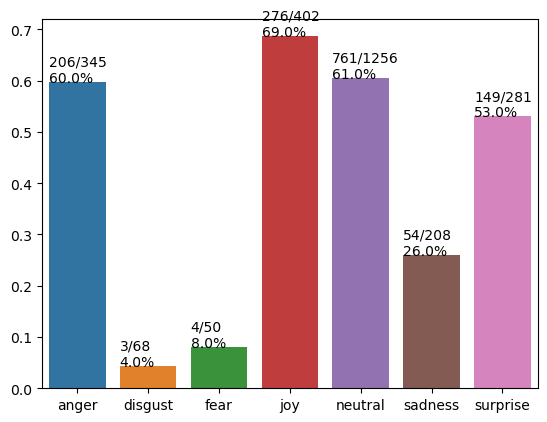

In [54]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
keys = list(class_acc.keys())
vals = [float(class_acc[k]/class_label_count[k]) for k in keys]
ax = sns.barplot(x=keys, y=vals)
xlbl = ax.get_xticklabels()
print(xlbl)
# print(ax.get_xticklabels())
# plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
# print(ax.axes)
# print(ax.get_xticklabels()[0].get_text())
# for i in ax.get_xticklabels():
        # print(i.get_text())
for i, p in enumerate(ax.patches): #patches
        print(p)
        lagend = xlbl[i].get_text()
        print(lagend)
        height = p.get_height()
        ax.text(p.get_x() , height, '{}/{}\n{}%'.format(class_acc[lagend], class_label_count[lagend],np.round(height,2)*100))
#         x, y, width, height = p.get_bbox().bounds
#         print(x)
#         print(p.())
#         print(p.get_label())
#         print(p.get_xticklabels())
        
#         print(p.get_xlabel())
        # ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)

plt.show()
# plt.savefig(save_path)

In [57]:
!python run.py -doing test

run
Rectangle(xy=(-0.4, 0), width=0.8, height=0.597101, angle=0)
anger
Rectangle(xy=(0.6, 0), width=0.8, height=0.0441176, angle=0)
disgust
Rectangle(xy=(1.6, 0), width=0.8, height=0.08, angle=0)
fear
Rectangle(xy=(2.6, 0), width=0.8, height=0.686567, angle=0)
joy
Rectangle(xy=(3.6, 0), width=0.8, height=0.605892, angle=0)
neutral
Rectangle(xy=(4.6, 0), width=0.8, height=0.259615, angle=0)
sadness
Rectangle(xy=(5.6, 0), width=0.8, height=0.530249, angle=0)
surprise


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaMod

In [59]:



!python run.py
